# Progetto Università: Analisi e Predizione Dati NYC Taxi 2024

**Obiettivo di questo Notebook (Punti 1-6):**
1.  **Punto 1:** Avviare una piattaforma Big Data (Spark).
2.  **Punto 2:** Importare il dataset.
3.  **Punto 3:** Eseguire la Data Exploration (prima su Spark per una visione d'insieme, poi su un campione Pandas per l'analisi visiva).
4.  **Punto 4:** Eseguire il Data Cleaning e la Feature Engineering sull'intero dataset usando Spark.
5.  **Punto 5:** Estrarre un dataset aggregato di interesse usando Spark.
6.  **Punto 6:** Salvare i dati puliti in un formato tidy (Parquet) per l'analisi successiva e il machine learning su Google Colab (Punti 7-9).

## Blocco 0: Setup Piattaforma e Caricamento Dati (Punti 1 e 2)

In [1]:
from pyspark.sql import SparkSession

# --- Punto 1: Setup della piattaforma Big Data ---
# Inizializziamo la SparkSession, che è il punto d'ingresso per ogni funzionalità di Spark.
spark = SparkSession.builder \
    .appName("TaxiPrediction") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.debug.maxToStringFields", 100) \
    .getOrCreate()

# --- Punto 2: Importare il dataset ---
df_taxi = spark.read.parquet("./2024-taxi-data/")

# Eseguiamo un .count() per verificare il volume totale dei dati.
print(f"Total runs number of 2024: {df_taxi.count()}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/07 10:19:25 WARN Utils: Your hostname, GOLDRAKE, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/07 10:19:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/07 10:19:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Total runs number of 2024: 41169720


### Punto 2: Fonte e Obiettivo

* **Fonte:** I dati provengono dal dataset pubblico "NYC TLC Trip Record Data" per l'anno 2024 (Yellow Taxis).
* **Tipologia di Analisi:** L'obiettivo è analizzare i fattori che influenzano la durata delle corse e creare un modello di **regressione** (Machine Learning) per **predire il tempo di percorrenza** (`trip_duration_sec`) di una corsa.

## Blocco 1: Data Exploration (Spark - Intero Dataset) (Punto 3)

Utilizziamo Spark per analizzare l'intero dataset. Questo ci darà la "verità" statistica sui nostri 41 milioni di record, necessaria per identificare outlier e dati sporchi che un piccolo campione potrebbe non mostrare.

In [2]:
# Comprendiamo lo schema dei dati (tipi di colonne)
df_taxi.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [3]:
# Visualizziamo le prime 5 righe per un controllo qualitativo
df_taxi.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-12-01 00:12:27|  2024-12-01 00:31:12|              1|         9.76|         1|                 N|         138|          33|           1|       38.0|  6.0|    0.5|      4.7

In [4]:
# --- Punto 3: Conferma su tutto il dataset ---
# Usiamo describe() su Spark per ottenere le statistiche principali (media, min, max) sull'intero dataset.
#
# - trip_distance (min: 0.0, max: 398608.62) -> Ci sono corse con distanza 0 o assurde.
# - passenger_count (min: 0.0) -> Corse con 0 passeggeri.
# - fare_amount (min: -2261.2) -> Tariffe negative.
# Questi sono tutti dati "sporchi" da rimuovere.
df_taxi.describe().show()

26/01/07 10:19:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 5:=====================================================>   (16 + 1) / 17]

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+
|summary|          VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|      fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------

In [5]:
# Controlliamo i valori NULLI su tutto il dataset.
from pyspark.sql.functions import col, count, when

# - Diverse colonne (es. passenger_count, RatecodeID) hanno ~4 milioni di valori NULL.
# - Questi record dovranno essere gestiti (rimossi o imputati) nella fase di Cleaning.
df_taxi.select([count(when(col(c).isNull(), c)).alias(c) for c in df_taxi.columns]).show()

[Stage 8:=======================>                                 (7 + 10) / 17]

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        4091232|            0|   4091232|           4091232|           0|           0|           0|          0|    0|      0|         

## Blocco 2: Data Exploration (Pandas - Campione) (Punto 3)

Ora campioniamo una piccola frazione dei dati (0.025%) e la convertiamo in un DataFrame Pandas. Questo ci permette di usare strumenti di visualizzazione rapida come Matplotlib e Seaborn per un'analisi più approfondita delle relazioni tra le variabili.

In [6]:
# Import necessari per l'analisi e la visualizzazione in Pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creiamo il campione 'df_test' (0.025% dei dati) e lo convertiamo in Pandas
df_taxi.sample(False, 0.00025, seed=42).write.mode("overwrite").parquet("campione.parquet")
df_taxi_c = spark.read.parquet("campione.parquet")
df_test = df_taxi_c.toPandas()

# Convertiamo le colonne data/ora in formato datetime di Pandas per poterle analizzare
df_test['tpep_pickup_datetime'] = pd.to_datetime(df_test['tpep_pickup_datetime'])
df_test['tpep_dropoff_datetime'] = pd.to_datetime(df_test['tpep_dropoff_datetime'])

Statistiche della durata sul campione (in secondi):
count    10465.000000
mean      1055.675203
std       2173.979781
min          0.000000
25%        465.000000
50%        771.000000
75%       1264.000000
max      86230.000000
Name: trip_duration_sec, dtype: float64


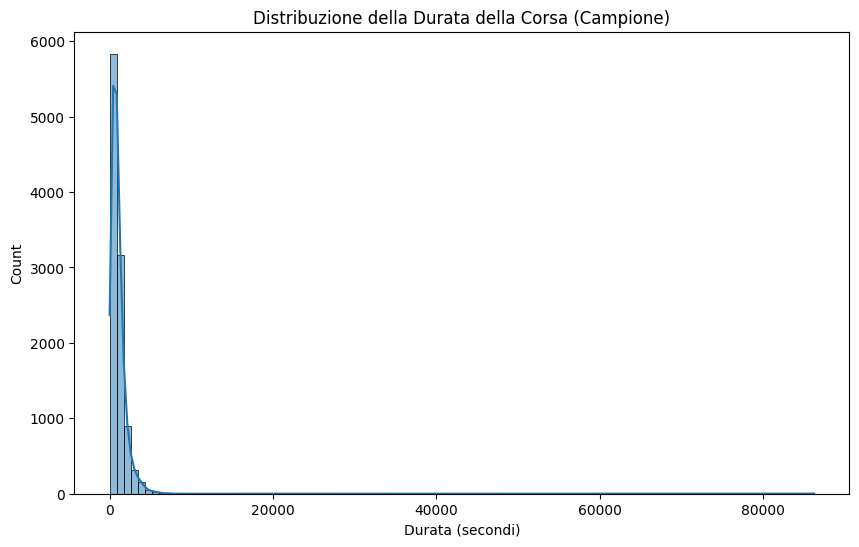

In [7]:
# --- Analisi della variabile Target (Durata) sul campione ---

# Creiamo la nostra colonna target 'trip_duration_sec' sul campione
df_test['trip_duration_sec'] = (df_test['tpep_dropoff_datetime'] - df_test['tpep_pickup_datetime']).dt.total_seconds()

print("Statistiche della durata sul campione (in secondi):")
print(df_test['trip_duration_sec'].describe())

# Visualizza la distribuzione
plt.figure(figsize=(10, 6))
sns.histplot(df_test['trip_duration_sec'], bins=100, kde=True)
plt.title('Distribuzione della Durata della Corsa (Campione)')
plt.xlabel('Durata (secondi)')
plt.show()

# - Il 'min' è 0.0, confermando le corse a durata nulla.
# - Il 'max' è molto alto (86291 sec = ~24 ore), confermando gli outlier.
# - Il grafico (istogramma) mostra una distribuzione fortemente "skewed" (asimmetrica a destra).
# - Questo ci suggerisce che per il ML sarà meglio usare il logaritmo della durata.


Distribuzione Tipi di Pagamento (Campione):
payment_type
1    7680
2    1468
0    1040
4     208
3      69
Name: count, dtype: int64


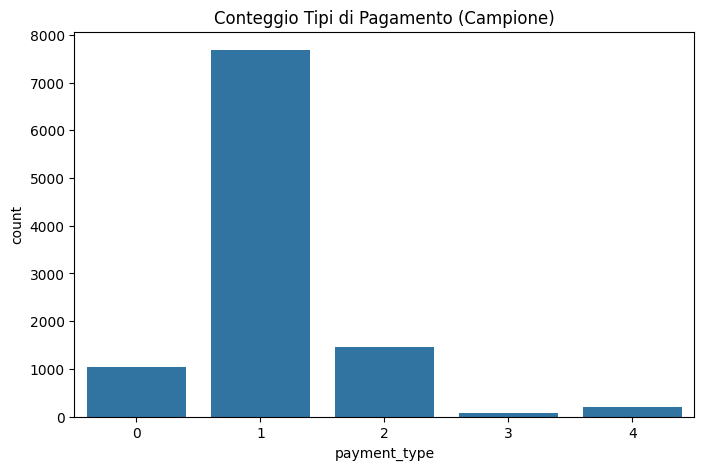

In [8]:
# --- Analisi Variabili Categoriche (Es: 'payment_type') sul campione ---
print("\nDistribuzione Tipi di Pagamento (Campione):")
print(df_test['payment_type'].value_counts())

# - La maggior parte delle corse è pagata con Carta (1) o Contanti (2).
# - Il valore '0' è anomalo (probabilmente un errore di inserimento), confermando la necessità di pulizia.
plt.figure(figsize=(8, 5))
sns.countplot(x='payment_type', data=df_test)
plt.title('Conteggio Tipi di Pagamento (Campione)')
plt.show()

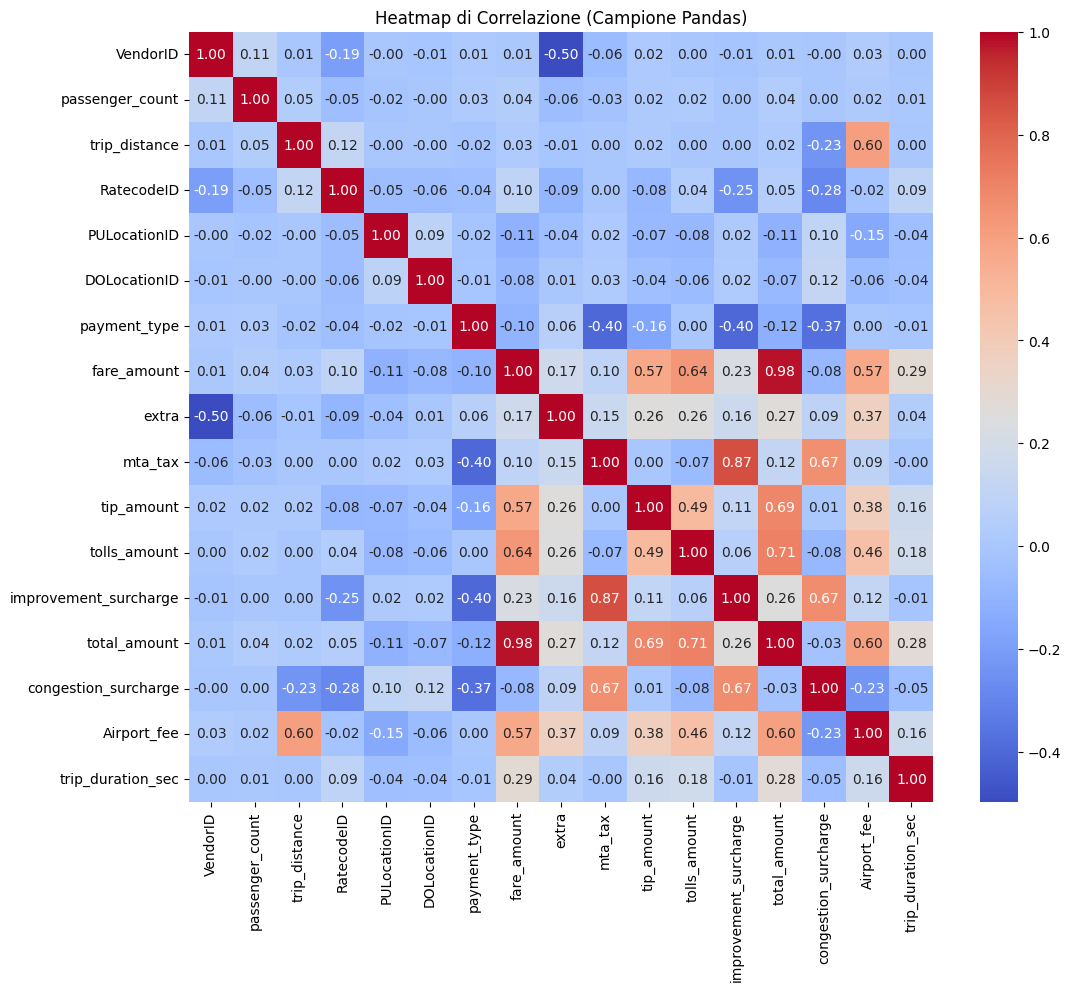

In [9]:
# --- Analisi delle Correlazioni sul campione ---

# Calcoliamo la matrice di correlazione per le variabili numeriche
correlation_matrix = df_test.corr(numeric_only=True)

# Visualizziamola con una Heatmap per identificare le relazioni più forti
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap di Correlazione (Campione Pandas)')
plt.show()

# - Osserviamo la riga/colonna 'trip_duration_sec'.
# - C'è una correlazione positiva (anche se non fortissima nel campione sporco) con 'trip_distance' (0.29) e 'fare_amount' (0.23). Questo ha senso logico.
# - 'PULocationID' e 'DOLocationID' hanno correlazione quasi 0. Questo ci dice che non sono variabili numeriche, ma **categoriche**, e andranno trattate come tali nel modello.

## Blocco 3: Data Cleaning e Feature Engineering (Spark) (Punto 4)

Ora applichiamo le scoperte fatte nell'esplorazione per pulire l'intero dataset e creare le feature necessarie per il modello.

In [10]:
# --- Punto 4 (Fase 1): Feature Engineering (Creazione Target) ---
from pyspark.sql.functions import col, unix_timestamp

# Calcoliamo la durata in secondi (Target) sull'intero DataFrame Spark.
df_taxi_with_duration = df_taxi.withColumn('trip_duration_sec', (unix_timestamp(col('tpep_dropoff_datetime')) - unix_timestamp(col('tpep_pickup_datetime'))))

In [11]:
# --- Punto 4 (Fase 2): Data Cleaning (Gestione Nulli) ---
# Come visto nel Blocco 1 (cella 9), abbiamo ~4 milioni di righe con valori nulli.
# L'opzione più sicura e pulita per un modello di predizione è rimuovere queste righe.

colonne_chiave_per_nulls = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'congestion_surcharge', 'Airport_fee']

righe_prima = df_taxi_with_duration.count()

df_cleaned_nulls = df_taxi_with_duration.dropna(subset=colonne_chiave_per_nulls)

righe_dopo = df_cleaned_nulls.count()

print(f"Righe prima di dropna: {righe_prima}")
print(f"Righe dopo di dropna: {righe_dopo}")
print(f"Righe rimosse: {righe_prima - righe_dopo}")

Righe prima di dropna: 41169720
Righe dopo di dropna: 37078488
Righe rimosse: 4091232


In [12]:
# --- Punto 4 (Fase 3): Data Cleaning (Filtro Outlier) ---
# Applichiamo i filtri per rimuovere i dati "sporchi" e gli outlier identificati nel Blocco 1 (cella 8).
# Usiamo il DataFrame 'df_cleaned_nulls' come input.

df_cleaned = df_cleaned_nulls.filter(
    # Filtri sulla DURATA (almeno 1 minuto, meno di 24 ore)
    (col('trip_duration_sec') > 60) & (col('trip_duration_sec') < 24 * 3600) &
    
    # Filtri sulla DISTANZA (almeno 0.1 miglia, meno di 100 miglia)
    (col('trip_distance') > 0.1) & (col('trip_distance') < 100) &
    
    # Filtri sui PASSEGGERI (almeno 1, meno di 8)
    (col('passenger_count') > 0) & (col('passenger_count') < 8) &
    
    # Filtri sulla TARIFFA (positiva e ragionevole)
    (col('fare_amount') > 0) & (col('fare_amount') < 1000) &
    
    # Filtri sul TOTALE (positivo e ragionevole)
    (col('total_amount') > 0) & (col('total_amount') < 1200)
)

In [13]:
# --- Punto 4 (Fase 4): Feature Engineering (Variabili Temporali) ---
# Estraiamo feature utili dalla data di pickup. 
# L'ora, il giorno della settimana e il mese sono fondamentali per catturare pattern di traffico e stagionalità.
from pyspark.sql.functions import hour, dayofweek, month

df_features = df_cleaned.withColumn('pickup_hour', hour(col('tpep_pickup_datetime'))) \
                       .withColumn('pickup_dayofweek', dayofweek(col('tpep_pickup_datetime'))) \
                       .withColumn('pickup_month', month(col('tpep_pickup_datetime')))

# Diamo un'occhiata al risultato finale pulito e arricchito
print("Dataset pulito e arricchito di features:")
df_features.show(5)

Dataset pulito e arricchito di features:
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------------+-----------+----------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_duration_sec|pickup_hour|pickup_dayofweek|pickup_month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------------+---------

## Blocco 4: Estrazione Dataset (Punti 5 e 6)

Ora estraiamo due dataset distinti:
1.  **Dataset Aggregato (Punto 5):** Per un'analisi aggregata (es. durata media per ora).
2.  **Dataset Tidy per ML (Punto 6):** Un campione del dataset pulito da passare a Colab per il Machine Learning.

In [14]:
# --- Punto 5: Estrarre un dataset di interesse (informazioni aggregate) ---
from pyspark.sql.functions import avg, count

print("Creazione del dataset aggregato...")

# Calcoliamo la durata media, distanza media e numero di corse per ora del giorno.
df_aggregated = df_features.groupBy("pickup_hour") \
    .agg(
        avg("trip_duration_sec").alias("avg_duration_sec"),
        avg("trip_distance").alias("avg_distance"),
        count("*").alias("trip_count")
    ) \
    .orderBy("pickup_hour")

print("Dati Aggregati da Spark (Punto 5):")
df_aggregated.show()

# Salviamo questo dataset aggregato per l'analisi e la visualizzazione (Punti 7 e 8)
df_aggregated.write.mode('overwrite').parquet("dati_taxi_aggregati.parquet")

Creazione del dataset aggregato...
Dati Aggregati da Spark (Punto 5):


+-----------+------------------+------------------+----------+
|pickup_hour|  avg_duration_sec|      avg_distance|trip_count|
+-----------+------------------+------------------+----------+
|          0| 935.3145033055397| 4.013437719167078|    949618|
|          1| 856.7596355482516| 3.470987681027227|    619451|
|          2| 795.5258860453288| 3.113097095929832|    403055|
|          3| 793.3195578917945|3.3989457419715485|    257584|
|          4|  926.449908029649| 5.023820685133587|    164727|
|          5|1076.2682687945894| 6.404024083467351|    193992|
|          6|1070.6411868964942| 4.972144718543111|    455878|
|          7| 992.5752128009985|3.7598164753913577|    922928|
|          8|1001.2070476460798|3.2360966218748928|   1296518|
|          9|1016.4682327411184|3.1443087926937308|   1502270|
|         10|1052.2560610759986| 3.168066429561902|   1657214|
|         11|1086.2183493418277|3.1429820431770943|   1799149|
|         12|1116.0973305437274|3.2349299183200078|   1

In [15]:
# --- Punto 6: Preparazione Dati Tidy per ML ---

# Selezioniamo solo le colonne che useremo come feature (X) e target (y) per il modello di predizione.
df_model_data = df_features.select(
    'trip_duration_sec',  # Il nostro Target (Y)
    'trip_distance',      # Feature (X)
    'passenger_count',    # Feature (X)
    'PULocationID',       # Feature (X)
    'DOLocationID',       # Feature (X)
    'payment_type',       # Feature (X)
    'pickup_hour',        # Feature (X)
    'pickup_dayofweek',   # Feature (X)
    'pickup_month',       # Feature (X)
    'fare_amount'         # Feature (X)
)

In [16]:
# --- Punto 6: Salvataggio Dati Tidy per ML ---

# L'intero dataset pulito è ancora troppo grande per Pandas/Colab.
# Estraiamo un campione casuale (es. 20%) dei dati puliti.
df_final_sample = df_model_data.sample(fraction=0.2, seed=42)

# Contiamo le righe per sicurezza
print(f"Righe nel campione finale per ML: {df_final_sample.count()}")

# Scriviamo il campione su disco in formato Parquet.
# Questo file verrà poi caricato su Google Colab.
df_final_sample.write.mode('overwrite').parquet("dati_taxi_puliti_per_ml.parquet")

Righe nel campione finale per ML: 7093651
